## NYU Death Rate Analysis

### Extrach the datasets using SODA.api

In [9]:
'''
Annual Population Estimates for New York State and Counties: Beginning 1970
https://dev.socrata.com/foundry/data.ny.gov/krt9-ym2k
 
Vital Statistics Deaths by Resident County, Region, Place of Death: Beginning 2003
https://health.data.ny.gov/Health/Vital-Statistics-Deaths-by-Resident-County-Region-/v6zf-ydez
'''

#Use SODA API to extract the data
from sodapy import Socrata
import pandas as pd

# Enter the information from those sections here
socrata_population_domain = 'data.ny.gov'
socrata_death_domain = 'health.data.ny.gov'
Death_dataset_identifier = '7z98-p7et'
Population_dataset_identifier = 'krt9-ym2k'
socrata_token = 'Ll5YWwpbFi3EZIPbJMXoNY5IU'

In [10]:
# Extract death dataset from 2003 to 2008. 
client = Socrata(socrata_death_domain, socrata_token)

query = """
select 
    *
where
    race_ethnicity_description != 'Total'
    and year >= 2003 and year <= 2008
"""

death_results = client.get(Death_dataset_identifier, query = query)
d_df = pd.DataFrame.from_dict(death_results)
d_df.head(3)

,county_name,deaths,race_ethnicity_description,region,year
0,Albany,2,White Non Hispanic,ROS,2003
1,Albany,3,Not Stated,ROS,2003
2,Albany,2841,Hispanic,ROS,2003


In [11]:
d_metadata = client.get_metadata(Death_dataset_identifier)
[x['name'] for x in d_metadata['columns']]

['Year', 'County Name', 'Region', 'Race or Ethnicity', 'Deaths']

In [12]:
# Extract population dataset from 2003 to 2008

client = Socrata(socrata_population_domain, socrata_token)

query = """
select 
    *
where
    year >= 2003 and year <= 2008
"""

population_results = client.get(Population_dataset_identifier, query = query)
p_df = pd.DataFrame.from_dict(population_results)
p_df['year'].unique()

array(['2003', '2004', '2005', '2006', '2007', '2008'], dtype=object)

In [13]:
p_metadata = client.get_metadata(Population_dataset_identifier)
[x['name'] for x in p_metadata['columns']]

['FIPS Code', 'Geography', 'Year', 'Program Type', 'Population']

In [14]:
p_df['geography'].unique()

array(['New York State', 'Albany County', 'Allegany County',
       'Bronx County', 'Broome County', 'Cattaraugus County',
       'Cayuga County', 'Chautauqua County', 'Chemung County',
       'Chenango County', 'Clinton County', 'Columbia County',
       'Cortland County', 'Delaware County', 'Dutchess County',
       'Erie County', 'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
       'Saratoga County', 'Schenectady County', 'Schoha

In [15]:
d_df['county_name'].unique()

array(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery',
       'Nassau', 'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontario',
       'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens',
       'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectady',
       'Schoharie', 'Schuyler', 'Seneca', 'St Lawrence', 'Steuben',
       'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype=object)

In [16]:
# Create a corresponding county dictionary. Ex: {Albany County : Albany , ...}
from collections import defaultdict
county_dict = defaultdict(str)

population_county_list = p_df['geography'].unique()
death_county_list = list(d_df['county_name'].unique())

In [17]:
for i in death_county_list:
    for j in population_county_list:
        if i in j:
            county_dict[i] = j
        
#Add St Lawrence in dictionary
county_dict['St Lawrence'] = 'St. Lawrence County'

### Merge the datasets

In [18]:
#Select the countries in dictionary 
population_county = [county_dict[i] for i in county_dict]
p_df = p_df[p_df["geography"].isin(population_county)]

#Append a new column 'county', which would be used on outer join later
d_df['geography'] = d_df['county_name'].map(county_dict)

# Remove irrelevant columns 
p_df = p_df.drop(['fips_code','program_type'], axis = 1)
d_df = d_df.drop(['region'], axis = 1)

# Combine two datasets at a county level
df = pd.merge(d_df, p_df, on = ['geography','year'], how='right')

# Remove the duplicate column 'geography', which is the same as county_name
df = df.drop(['geography'], axis = 1)
df.head()

,county_name,deaths,race_ethnicity_description,year,population
0,Albany,2,White Non Hispanic,2003,301085
1,Albany,3,Not Stated,2003,301085
2,Albany,2841,Hispanic,2003,301085
3,Allegany,4,White Non Hispanic,2003,50165
4,Allegany,480,Hispanic,2003,50165


In [19]:
print("The shape of dataset :", df.shape)

The shape of dataset : (793, 5)


### Data Cleaning and Data Preprocessing

In [20]:
# Check whether the NA value exists or not. Awesome! There is no missing value inside. 
df.isnull().sum()

county_name                   0
deaths                        0
race_ethnicity_description    0
year                          0
population                    0
dtype: int64

In [21]:
# export the data as df.xlsx and examine 
writer = pd.ExcelWriter('df.xlsx')
df.to_excel(writer,'df')
writer.save()

In [22]:
# Change the data type from string to number
df[['deaths']] = df[['deaths']].astype('int32')
df[['population']] = df[['population']].astype('int32')

In [23]:
df.head()

,county_name,deaths,race_ethnicity_description,year,population
0,Albany,2,White Non Hispanic,2003,301085
1,Albany,3,Not Stated,2003,301085
2,Albany,2841,Hispanic,2003,301085
3,Allegany,4,White Non Hispanic,2003,50165
4,Allegany,480,Hispanic,2003,50165


### Exploratory Data Analysis

In [24]:
df.describe()

,deaths,population
count,793.000000,7.930000e+02
mean,1134.322825,4.705027e+05
std,2809.188686,6.296940e+05
min,1.000000,4.893000e+03
25%,1.000000,6.429200e+04
50%,8.000000,1.561040e+05
75%,692.000000,7.383290e+05
max,17766.000000,2.472999e+06


In [25]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:6])

county_name             62	 ['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga']
deaths                 359	 [1, 2, 3, 4, 5, 6]
race_ethnicity_description     5	 ['Black Non Hispanic', 'Hispanic', 'Not Stated', 'Other Non Hispanic', 'White Non Hispanic']
year                     6	 ['2003', '2004', '2005', '2006', '2007', '2008']
population             370	 [4893, 4969, 4987, 5093, 5158, 5181]


In [26]:
df['county_name'].unique()

array(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery',
       'Nassau', 'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontario',
       'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens',
       'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectady',
       'Schoharie', 'Schuyler', 'Seneca', 'St Lawrence', 'Steuben',
       'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype=object)

In [27]:
# New York city consists of Kings, Queens, Richmond, and Bronx
# To visualize clearly, I create a new feature 'Location' and map the different counties based on its geographic location. 
NyCity = ['Kings', 'Queens', 'Richmond', 'Bronx']

West = ['Wayne','Allegany','Erie','Wyoming','Orleans','Chemung','Monroe','Yates','Schuyler','Niagara',
 'Seneca','Steuben','Chautauqua','Cattaraugus','Livingston','Ontario','Genesee']

Mid = ['St. Lawrence','Lewis','Jefferson','Herkimer','Onondaga',
 'Cayuga','Cortland','Tompkins','Broome','Oneida','Oswego','Tioga','Chenango','Madison']

South = ['Ulster','Dutchess','Putnam','Orange','Sullivan','Rockland','Westchester','Suffolk','Nassau']

East = ['Franklin','Clinton','Essex','Hamilton','Warren','Saratoga','Washington','Columbia','Schenectady'
,'Rensselaer','Delaware','Otsego','Greene','Albany','Fulton','Montgomery','Schoharie']

Geo_dict={}
district = ['West','Mid','South','East','NyCity']
for index,geo_list in enumerate([West,Mid,South,East,NyCity]):
    for county in geo_list:
        Geo_dict[county] = district[index]

df['Location'] = df['county_name'].map(Geo_dict)
df.head(10)

,county_name,deaths,race_ethnicity_description,year,population,Location
0,Albany,2,White Non Hispanic,2003,301085,East
1,Albany,3,Not Stated,2003,301085,East
2,Albany,2841,Hispanic,2003,301085,East
3,Allegany,4,White Non Hispanic,2003,50165,West
4,Allegany,480,Hispanic,2003,50165,West
5,Bronx,3,White Non Hispanic,2003,1362373,NyCity
6,Bronx,8,Black Non Hispanic,2003,1362373,NyCity
7,Bronx,10072,Hispanic,2003,1362373,NyCity
8,Broome,1,Not Stated,2003,201037,Mid
9,Broome,5,Black Non Hispanic,2003,201037,Mid


In [28]:
# From the table above, I noticed that there are extremely high hispanic deaths compared to other races. 
# So first I would like to check the total death ratio based on different races.

import numpy as np
import pandas as pd

temp = df[['year','population','county_name','deaths','Location']]

temp = df.groupby(['race_ethnicity_description']).agg({'deaths': np.sum}).reset_index()
temp.head()

,race_ethnicity_description,deaths
0,Black Non Hispanic,235
1,Hispanic,898266
2,Not Stated,156
3,Other Non Hispanic,34
4,White Non Hispanic,827


In [29]:
df.Location.value_counts().iloc[:5].index

Index(['West', 'South', 'East', 'Mid', 'NyCity'], dtype='object')

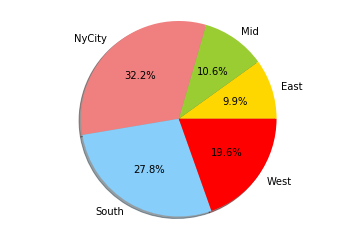

In [30]:
# The total death ratio pie chart from 2003 to 2008
temp1 = df.groupby(['Location']).agg({'deaths': np.sum}).reset_index()
import matplotlib.pyplot as plt
labels = list(temp1['Location'].values)
size = list(temp1['deaths'].values) 
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red']
plt.pie(size, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True)

plt.axis('equal')
plt.show()

In [31]:
# In order to get the correct population in different district without aggregating duplicate rows, 
# I created a temp2 dataset to calculate the population based on locations and drop duplicate rows.
temp2 = df[['population','Location']]

# Drop duplicates except for the first occurrence.
temp2 = temp2.drop_duplicates(keep='first')
temp2 = temp2.groupby(['Location']).agg({'population': np.sum}).reset_index()
death_rate_location = pd.merge(temp2, temp1, on = ['Location'], how='inner')
death_rate_location['Death_rate'] = death_rate_location['deaths']/death_rate_location['population'] * 100
death_rate_location

,Location,population,deaths,Death_rate
0,East,8946621,82337,0.920314
1,Mid,9770896,87885,0.899457
2,NyCity,38748414,266943,0.688913
3,South,30353859,230514,0.759422
4,West,16988230,162548,0.956827


In [32]:
num = death_rate_location['deaths'].sum() / death_rate_location['population'].sum()
print('The average death rate during the 6 years is {0} %'.format(num*100))

The average death rate during the 6 years is 0.7921407159490276 %


/Users/glen/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


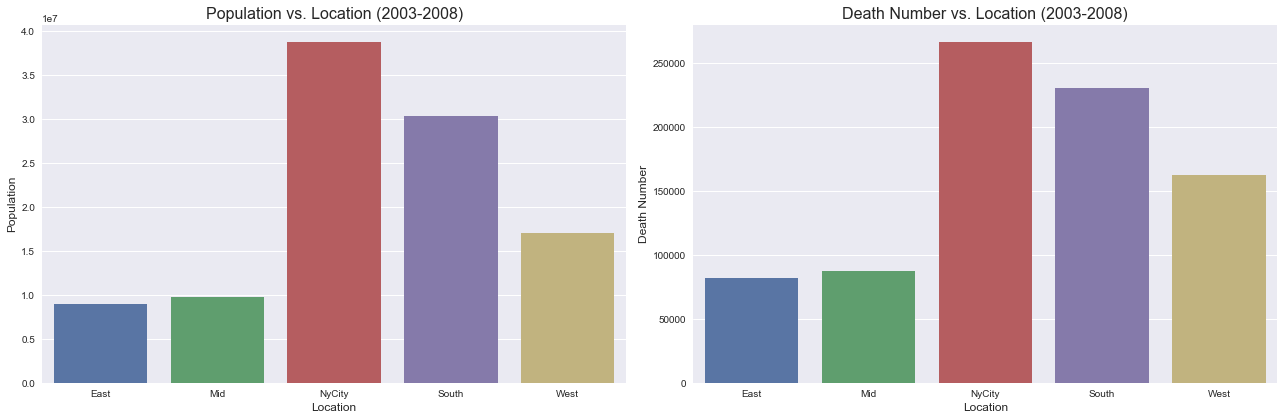

In [33]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='Location', y='population', data=death_rate_location, ax=ax[0])
ax[0].set_xlabel('Location', fontsize=12)
ax[0].set_ylabel('Population', fontsize=12)
ax[0].set_title('Population vs. Location (2003-2008)', fontsize=16)


sns.barplot(x='Location', y='deaths', data=death_rate_location, ax=ax[1])
ax[1].set_xlabel('Location', fontsize=12)
ax[1].set_ylabel('Death Number', fontsize=12)
ax[1].set_title('Death Number vs. Location (2003-2008)', fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
# Create a new dataset death_rate_county 
death_df = df.groupby(['county_name','year']).agg({'deaths': np.sum}).reset_index()
population_df = df[['population','year','county_name','Location']]
population_df = population_df.drop_duplicates(keep='last')
death_rate_county = pd.merge(population_df, death_df, on = ['county_name','year'], how='inner')
death_rate_county.head()

,population,year,county_name,Location,deaths
0,301085,2003,Albany,East,2846
1,50165,2003,Allegany,West,484
2,1362373,2003,Bronx,NyCity,10083
3,201037,2003,Broome,Mid,2061
4,83335,2003,Cattaraugus,West,839


/Users/glen/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


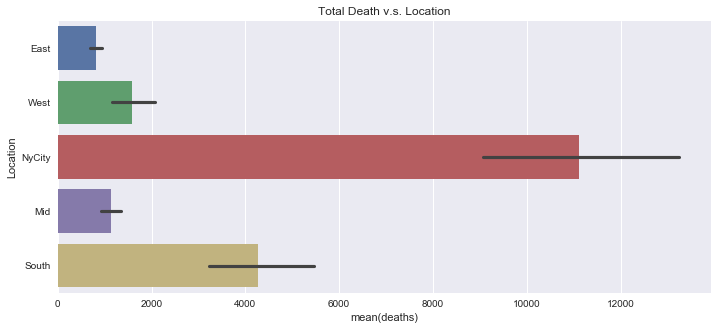

In [35]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,5)})
ax = sns.barplot(x = 'deaths',y="Location", data=death_rate_county).set_title("Total Death v.s. Location")
plt.show()

In [36]:
# Aggregate the data at the year and the county level and create a new dataset group
group = death_rate_county.groupby(['county_name','year']).agg({'deaths': np.sum, 'population':np.sum}).reset_index()
group['Death_rate(Percent)'] = group['deaths']/group['population'] * 100

group_2004 = group[group['year'] == '2004'].nlargest(5,'Death_rate(Percent)')
group_2004

,county_name,year,deaths,population,Death_rate(Percent)
169,Montgomery,2004,628,49460,1.269713
121,Hamilton,2004,61,5158,1.182629
127,Herkimer,2004,717,64332,1.114531
61,Columbia,2004,706,63646,1.109261
91,Essex,2004,431,39295,1.096832


/Users/glen/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


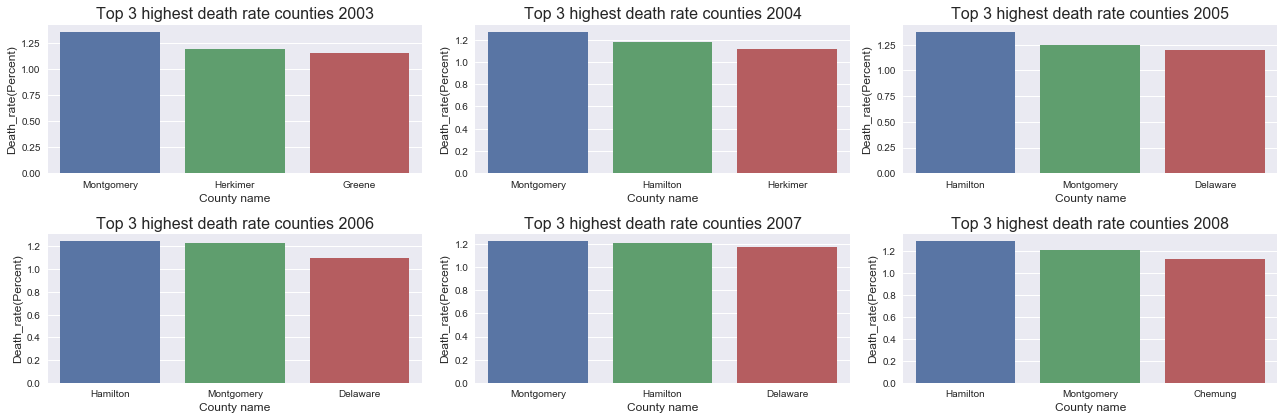

In [37]:
# Write a function print_highest_counties to help me print the result in different year 
year = ['2003','2004','2005','2006','2007','2008']
group = death_rate_county.groupby(['county_name','year']).agg({'deaths': np.sum, 'population':np.sum}).reset_index()
group['Death_rate(Percent)'] = group['deaths']/group['population'] * 100


def print_highest_counties(year, row, col, group, c):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(18, 6))
    for i in range(row):
        for j in range(col):
            group1 = group[group['year'] == year[c]].nlargest(3,'Death_rate(Percent)')
            sns.barplot(x='county_name', y='Death_rate(Percent)', data=group1, ax=ax[i][j])
            ax[i][j].set_xlabel('County name', fontsize=12)
            ax[i][j].set_ylabel('Death_rate(Percent)', fontsize=12)
            ax[i][j].set_title('Top 3 highest death rate counties {0}'.format(year[c]), fontsize=16)
            c+=1

print_highest_counties(year, 2, 3, group, 0)
plt.tight_layout()
plt.show()

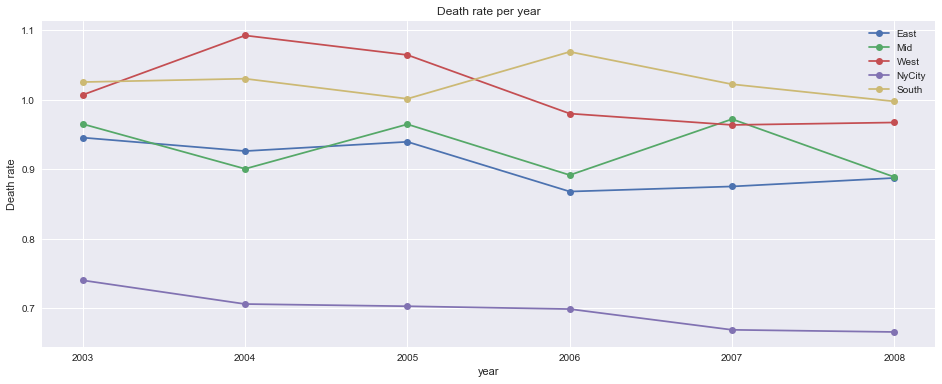

In [38]:
# # Aggregate the data at the year and the location level and create a new dataset temp
temp = death_rate_county.groupby(['Location','year']).agg({'deaths': np.sum, 'population':np.sum}).reset_index()
temp['Death_rate(Percent)'] = group['deaths']/group['population'] * 100

temp1 = temp[temp['Location'] == 'East']
temp2 = temp[temp['Location'] == 'Mid']
temp3 = temp[temp['Location'] == 'West']
temp4 = temp[temp['Location'] == 'NyCity']
temp5 = temp[temp['Location'] == 'South']

plt.figure(figsize=(16, 6))

plt.xlabel('year')
plt.ylabel('Death rate')

plt.plot(temp1['year'], temp1['Death_rate(Percent)'], 'o-')
plt.plot(temp2['year'], temp2['Death_rate(Percent)'], 'o-')
plt.plot(temp3['year'], temp3['Death_rate(Percent)'], 'o-')
plt.plot(temp4['year'], temp4['Death_rate(Percent)'], 'o-')
plt.plot(temp5['year'], temp5['Death_rate(Percent)'], 'o-')
plt.title('Death rate per year')
plt.legend(['East', 'Mid', 'West', 'NyCity','South'], loc='upper right')

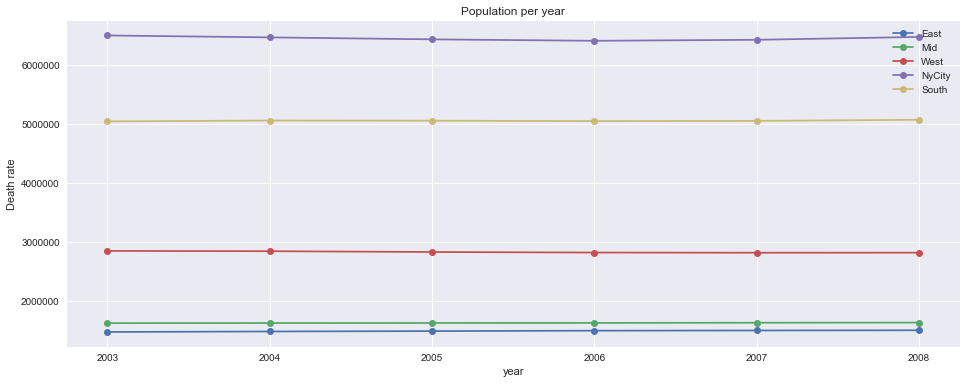

In [39]:
# Plot population per year
temp1 = temp[temp['Location'] == 'East']
temp2 = temp[temp['Location'] == 'Mid']
temp3 = temp[temp['Location'] == 'West']
temp4 = temp[temp['Location'] == 'NyCity']
temp5 = temp[temp['Location'] == 'South']

plt.figure(figsize=(16, 6))

plt.xlabel('year')
plt.ylabel('Death rate')

plt.plot(temp1['year'], temp1['population'], 'o-')
plt.plot(temp2['year'], temp2['population'], 'o-')
plt.plot(temp3['year'], temp3['population'], 'o-')
plt.plot(temp4['year'], temp4['population'], 'o-')
plt.plot(temp5['year'], temp5['population'], 'o-')
plt.title('Population per year')
plt.legend(['East', 'Mid', 'West', 'NyCity','South'], loc='upper right')